# 謠言分類實作報告 Rumor Detection on Twitter

## 資料簡介
PHEME資料集記錄了Twitter使用者在重大事件發生期間所發布的謠言和非謠言tweet紀錄。

#### 目錄結構如下：

- 事件A
    - 謠言
        - twitter_id_1
        - twitter_id_2
        - twitter_id_3
        - ...
    - 非謠言
        - twitter_id_1
        - twitter_id_2
        - twitter_id_3
        - ...
- 事件B
- 事件C
- ...

## 讀取資料
利用 python 原生 JSON 讀取功能讀取所有資料。

我們分為：
- dataset_original: 只有原tweet的資料集
- dataset_with_reactions: 包含reaction的tweet資料集

In [1]:
import os
import json
from tqdm import tqdm, trange
from pprint import pprint

PATH_ROOT = "./200g/dataset/training"

def parse_structure(mapper):
    if type(mapper) == list:
        return []
    mk_init = list(mapper.keys())
    q = list(zip(["root" for _ in range(len(mk_init))], mk_init, [mapper[k] for k in mk_init]))
    while(len(q) != 0):
        prev_id = q[0][0]
        this_id = q[0][1]
        this_mapper = q[0][2]
        yield (prev_id, this_id)
        if type(this_mapper) != list:
            for qk in this_mapper.keys():
                q.append((this_id, qk, this_mapper[qk]))
        q = q[1:]
        
dataset = {"raw_X":[], "Y":[]}
for event_name in os.listdir(PATH_ROOT):
    if ".ipynb" in event_name:
        continue
    # non-rumors
    dir_path = PATH_ROOT + '/' + event_name + '/non-rumours'
    for twitter_id in tqdm(os.listdir(dir_path)):
        if ".ipynb" in twitter_id:
            continue
        with open(dir_path + '/' + twitter_id + '/source-tweets/' + twitter_id + '.json', 'r') as f:
            this_json = json.load(f)
            root_text = this_json['text'].replace("|||","")
            this_user = this_json['user']['screen_name']
        with open(dir_path + '/' + twitter_id + '/structure.json', 'r') as f:
            structure_json = json.load(f)
        dataset['raw_X'].append({'main':root_text, 'sub':[], 'user':this_user})
        dataset['Y'].append(0)
        text_pairs = list(parse_structure(structure_json[twitter_id]))
        if len(text_pairs) > 0:
            for text_pair in text_pairs:
                prev_id, curr_id = text_pair[0], text_pair[1]
                if prev_id == 'root':
                    this_X = root_text + " ||| "
                else:
                    with open(dir_path + '/' + twitter_id + '/reactions/' + prev_id + ".json", 'r') as f:
                        this_json = json.load(f)
                        this_X = this_json['text'].replace("|||","") + " ||| "
                with open(dir_path + '/' + twitter_id + '/reactions/' + curr_id + ".json", 'r') as f:
                    this_json = json.load(f)
                    this_X += this_json['text']
                dataset['raw_X'][-1]['sub'].append(this_X)
        
    # rumors
    dir_path = PATH_ROOT + '/' + event_name + '/rumours'
    for twitter_id in tqdm(os.listdir(dir_path)):
        if ".ipynb" in twitter_id:
            continue
        with open(dir_path + '/' + twitter_id + '/source-tweets/' + twitter_id + '.json', 'r') as f:
            this_json = json.load(f)
            root_text = this_json['text'].replace("|||","")
            this_user = this_json['user']['screen_name']
        with open(dir_path + '/' + twitter_id + '/structure.json', 'r') as f:
            structure_json = json.load(f)
        dataset['raw_X'].append({'main':root_text, 'sub':[], 'user':this_user})
        dataset['Y'].append(1)
        text_pairs = list(parse_structure(structure_json[twitter_id]))
        if len(text_pairs) > 0:
            for text_pair in text_pairs:
                prev_id, curr_id = text_pair[0], text_pair[1]
                if prev_id == 'root':
                    this_X = root_text + " ||| "
                else:
                    with open(dir_path + '/' + twitter_id + '/reactions/' + prev_id + ".json", 'r') as f:
                        this_json = json.load(f)
                        this_X = this_json['text'].replace("|||","") + " ||| "
                with open(dir_path + '/' + twitter_id + '/reactions/' + curr_id + ".json", 'r') as f:
                    this_json = json.load(f)
                    this_X += this_json['text']
                dataset['raw_X'][-1]['sub'].append(this_X)


100%|██████████| 284/284 [00:00<00:00, 465.82it/s]


## 資料清理並進行統計

- 將所有文字 uncase (變成小寫)
- 保留usertag、url和hashtag (因為hashtag裡面有文字訊息)
- 保留其他語言文字 (不移除特殊feature)
- 對句長進行敘述統計

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#大小寫轉換
for i in trange(len(dataset['raw_X'])):
    this_x = dataset['raw_X'][i]['main']
    this_x = this_x.lower()
    dataset['raw_X'][i]['main'] = this_x
    for j in range(len(dataset['raw_X'][i]['sub'])):
        this_x = dataset['raw_X'][i]['sub'][j]
        this_x = this_x.lower()
        dataset['raw_X'][i]['sub'][j] = this_x

100%|██████████| 5802/5802 [00:00<00:00, 67085.55it/s]


[original]
count    5802.000000
mean       16.205963
std         4.572858
min         3.000000
25%        13.000000
50%        16.000000
75%        19.000000
max        31.000000
Name: X_Length, dtype: float64


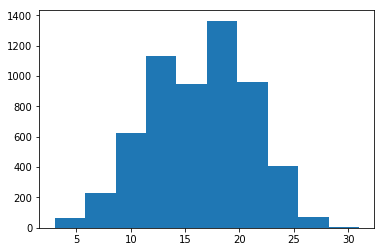

In [3]:
print("[original]")
df_org = pd.DataFrame({'X':[d['main'] for d in dataset['raw_X']], 'Y':dataset['Y']})
df_org['X_Length'] = df_org['X'].apply(lambda x: len(x.split()))
plt.hist(df_org['X_Length'])
print(df_org['X_Length'].describe())

[with reactions]
count    99253.000000
mean        28.144318
std          9.253973
min          2.000000
25%         21.000000
50%         28.000000
75%         35.000000
max         58.000000
Name: X_Length, dtype: float64


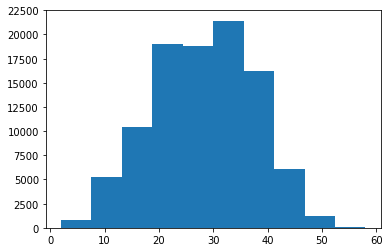

In [4]:
print("[with reactions]")
dx = []
dy = []
for t in range(len(dataset['raw_X'])):
    dx.append(dataset['raw_X'][t]['main'])
    dy.append(dataset['Y'][t])
    for tt in dataset['raw_X'][t]['sub']:
        dx.append(tt)
        dy.append(dataset['Y'][t])
df_react = pd.DataFrame({'X':dx, 'Y':dy})
df_react['X_Length'] = df_react['X'].apply(lambda x: len(x.replace(" ||| ","").split()))
plt.hist(df_react['X_Length'])
print(df_react['X_Length'].describe())

先切好 train-test-set 來減少後續進行作業。

In [5]:
from sklearn.model_selection import train_test_split

Xtrain_raw, Xtest_raw, Ytrain_org, Ytest_org = train_test_split(dataset['raw_X'], dataset['Y'], test_size=0.2, random_state=0)

Xtrain_org_raw = [d['main'] for d in Xtrain_raw]
Xtest_org_raw = [d['main'] for d in Xtest_raw]

Xtrain_react_raw = []
Ytrain_react = []
for i in range(len(Xtrain_raw)):
    Xtrain_react_raw.append(Xtrain_raw[i]['main'])
    Ytrain_react.append(Ytrain_org[i])
    for xx in Xtrain_raw[i]['sub']:
        Xtrain_react_raw.append(xx)
        Ytrain_react.append(Ytrain_org[i])
Xtest_react_raw = []
Ytest_react = Ytest_org.copy()
for i in range(len(Xtest_raw)):
    Xtest_react_raw.append([Xtest_raw[i]['main']])
    for xx in Xtest_raw[i]['sub']:
        Xtest_react_raw[-1].append(xx)

assert len(Xtrain_react_raw) == len(Ytrain_react)
assert len(Xtest_react_raw) == len(Ytest_react)

## 取得 BERT 的 embedding

使用 bert-as-service 來取得 BERT-Embedding (max_seq_len=100)

In [6]:
from bert_serving.client import BertClient
bc = BertClient()

#使用 100 作為 BERT max sequence length
print("start original...",end='')
Xtrain_org = bc.encode(Xtrain_org_raw)
Xtest_org = bc.encode(Xtest_org_raw)
print("DONE!")

print("start with reactions...",end='')
Xtrain_react = bc.encode(Xtrain_react_raw)
Xtest_react = []
for x in Xtest_react_raw:
    Xtest_react.append(bc.encode(x))
Xtest_react = np.array(Xtest_react)
print("DONE!")

start original...DONE!
start with reactions...DONE!


利用 joblib 輸出為 pickle 檔，並清除不必要資料 (避免佔用記憶體空間)

In [7]:
import gc
import joblib

print("start dumping dataset_original...", end='')
df_org.to_csv('./200g/dataset/dataset_original.csv',index=False)
joblib.dump({'X_train':Xtrain_org, 'Y_train':Ytrain_org, 'X_test':Xtest_org, 'Y_test':Ytest_org},
            './200g/dataset/dataset_original.pkl', protocol=4)
print("DONE!")
del Xtrain_org_raw
del Xtest_org_raw
del df_org

print("start dumping dataset_with_reactions...", end='')
df_react.to_csv('./200g/dataset/dataset_with_reactions.csv',index=False)
joblib.dump({'X_train':Xtrain_react, 'Y_train':Ytrain_react, 'X_test':Xtest_react, 'Y_test':Ytest_react},
            './200g/dataset/dataset_with_reactions.pkl', protocol=4)
print("DONE!")
del Xtrain_react_raw
del Xtest_react_raw
del df_react

_ = gc.collect()

start dumping dataset_original...DONE!
start dumping dataset_with_reactions...DONE!


## 開始訓練模型

我們比較了兩種不同的模型:
- 傳統 Logistic Regression - 使用Cross Validation找出超參數
- 深度學習 BiDirectional LSTM - 

在那之前，我們先檢查資料分布，以決定是否調整 class weight (解決 unbalanced 問題)

class#0 有 3830 個, 占比66.01%
class#1 有 1972 個, 占比33.99%


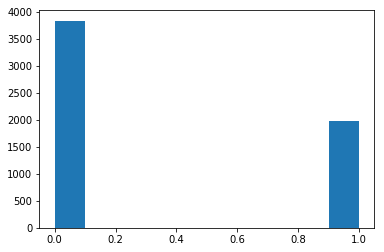

In [8]:
plt.hist(dataset['Y'])

v,c = np.unique(dataset['Y'], return_counts=True)
total_count = len(dataset['Y'])
for vv,cc in zip(v,c):
    print("class#%d 有 %4d 個, 占比%.2f%%"%(vv,cc,cc*100/total_count))

...可見是一個非常需要調整 class weight 的二元分類問題。

## 前置作業

In [69]:
import multiprocessing
import gc
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve, auc

# 取得運行的CPU數量
NJOBS = max(multiprocessing.cpu_count()-2, 1)

# 定義評估函式
myscorer = make_scorer(
         roc_auc_score,
         greater_is_better=True
)

# 繪製ROC曲線
def draw_ROC(labels, y, yps, title):
    plt.title(title)
    for i in range(len(labels)):
        y_true = y
        y_prop = yps[i]
        label = labels[i]
        fpr, tpr, threshold = roc_curve(y_true, y_prop)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = '%s = %0.4f' % (label, roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegressionCV

lr = LogisticRegressionCV(Cs=20, scoring=myscorer, random_state=0, max_iter=100000, class_weight='balanced', n_jobs=NJOBS).fit(Xtrain_org, Ytrain_org)
joblib.dump(lr, './200g/trained_models/LogisticRegressionCV_org.pkl', protocol=4)
del lr

#大資料使用多執行緒時會出錯，故取消n_jobs調用
lr = LogisticRegressionCV(Cs=20, scoring=myscorer, random_state=0, max_iter=100000, class_weight='balanced').fit(Xtrain_react, Ytrain_react)
joblib.dump(lr, './200g/trained_models/LogisticRegressionCV_react.pkl', protocol=4)
del lr

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


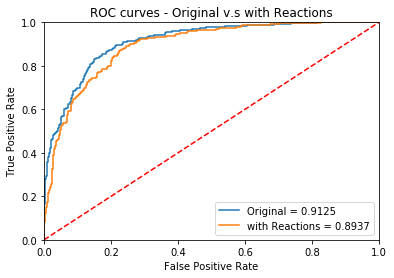

[original]
              precision    recall  f1-score   support

   non-rumor       0.91      0.82      0.86       755
       rumor       0.72      0.85      0.78       406

    accuracy                           0.83      1161
   macro avg       0.82      0.84      0.82      1161
weighted avg       0.85      0.83      0.84      1161



[with reactions]
              precision    recall  f1-score   support

   non-rumor       0.90      0.79      0.84       755
       rumor       0.68      0.83      0.75       406

    accuracy                           0.80      1161
   macro avg       0.79      0.81      0.79      1161
weighted avg       0.82      0.80      0.81      1161



In [70]:
from sklearn.metrics import classification_report

def with_reaction_lr_model_predict(model, X, thresh=0.5): #return predict, prob
    this_y_prob = []
    this_y = []
    for i,x in enumerate(X):
        _y = model.predict(x)
        if sum(_y) > len(x)*thresh:
            this_y.append(1)
        else:
            this_y.append(0)
        _y = model.predict_proba(x)[:,1]
        _y_prob = sum(_y)/len(x)
        this_y_prob.append(_y_prob)
    return this_y, this_y_prob

lr1 = joblib.load('./200g/trained_models/LogisticRegressionCV_org.pkl')
lr2 = joblib.load('./200g/trained_models/LogisticRegressionCV_react.pkl')

lr1_y_prob = lr1.predict_proba(Xtest_org)[:,1]
lr1_y = lr1.predict(Xtest_org)
lr2_y, lr2_y_prob = with_reaction_lr_model_predict(lr2, Xtest_react)

draw_ROC(["Original","with Reactions"], Ytest_org, [lr1_y_prob,lr2_y_prob], 'ROC curves - Original v.s with Reactions')

print("[original]")
print(classification_report(Ytest_org, lr1_y, target_names=['non-rumor','rumor']))
print("\n\n[with reactions]")
print(classification_report(Ytest_react, lr2_y, target_names=['non-rumor','rumor']))

del lr1
del lr2
_ = gc.collect()

### Multi-Layer Perceptrons

In [44]:
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Activation
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight

# 建立訓練模型時的auc-roc評估函式
def auc_roc(y_true, y_pred):
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value
    
# 建立訓練模型時的callbak函式集合
def get_callbacks(output_path):
    earlyStopping = EarlyStopping(monitor='val_loss', patience=14, verbose=1, mode='min')
    mcp_save = ModelCheckpoint('./200g/trained_models/%s/model-{auc_roc:03f}.h5'%output_path, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
    return [earlyStopping, mcp_save, reduce_lr_loss]

# MLP模型建立
def get_model():
    model = Sequential()
    model.add(Dense(128, input_shape = (768,))) 
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy', auc_roc])
    model.summary()
    return model
    

In [53]:
from sklearn.model_selection import StratifiedKFold

folds = list(StratifiedKFold(n_splits=20, shuffle=True, random_state=1).split(Xtrain_org, Ytrain_org))

for j, (train_idx, val_idx) in enumerate(folds):
    print('\nFold ',j+1)
    X_train_cv = np.array(Xtrain_org)[train_idx]
    y_train_cv = np.array(Ytrain_org)[train_idx]
    X_valid_cv = np.array(Xtrain_org)[val_idx]
    y_valid_cv= np.array(Ytrain_org)[val_idx]
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_cv), y_train_cv)
    my_callbacks = get_callbacks('MLP_org')
    model = get_model()
    model.fit(X_train_cv, y_train_cv,
              validation_data=(X_valid_cv, y_valid_cv),
              shuffle=True,
              batch_size=128,
              epochs=100,
              class_weight=class_weights,
              callbacks=my_callbacks)


Fold  1


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_116 (Dense)            (None, 128)               98432     
_________________________________________________________________
activation_115 (Activation)  (None, 128)               0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_117 (Dense)            (None, 64)                8256      
_________________________________________________________________
activation_116 (Activation)  (None, 64)                0         
_________________________________________________________________
dropout_78 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_118 (Dense)            (None, 1)               

In [54]:
folds = list(StratifiedKFold(n_splits=20, shuffle=True, random_state=1).split(Xtrain_react, Ytrain_react))

for j, (train_idx, val_idx) in enumerate(folds):
    print('\nFold ',j+1)
    X_train_cv = np.array(Xtrain_react)[train_idx]
    y_train_cv = np.array(Ytrain_react)[train_idx]
    X_valid_cv = np.array(Xtrain_react)[val_idx]
    y_valid_cv= np.array(Ytrain_react)[val_idx]
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_cv), y_train_cv)
    my_callbacks = get_callbacks('MLP_react')
    model = get_model()
    model.fit(X_train_cv, y_train_cv,
              validation_data=(X_valid_cv, y_valid_cv),
              shuffle=True,
              batch_size=128,
              epochs=100,
              class_weight=class_weights,
              callbacks=my_callbacks)


Fold  1


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_176 (Dense)            (None, 128)               98432     
_________________________________________________________________
activation_175 (Activation)  (None, 128)               0         
_________________________________________________________________
dropout_117 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_177 (Dense)            (None, 64)                8256      
_________________________________________________________________
activation_176 (Activation)  (None, 64)                0         
_________________________________________________________________
dropout_118 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_178 (Dense)            (None, 1)               

KeyboardInterrupt: 

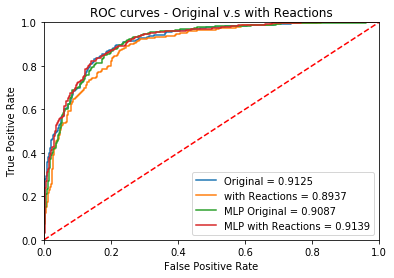

[MLP original]
              precision    recall  f1-score   support

   non-rumor       0.77      0.96      0.86       755
       rumor       0.87      0.48      0.61       406

    accuracy                           0.79      1161
   macro avg       0.82      0.72      0.74      1161
weighted avg       0.81      0.79      0.77      1161



[MLP with reactions]
              precision    recall  f1-score   support

   non-rumor       0.83      0.91      0.87       755
       rumor       0.80      0.66      0.72       406

    accuracy                           0.82      1161
   macro avg       0.82      0.79      0.80      1161
weighted avg       0.82      0.82      0.82      1161



In [71]:
from keras.models import load_model

def with_reaction_mlp_model_predict(model, X, thresh=0.5): #return predict, prob
    this_y_prob = []
    this_y = []
    for x in X:
        _y = model.predict_classes(x)
        if sum(_y) > len(x)*thresh:
            this_y.append(1)
        else:
            this_y.append(0)
        _y = model.predict_proba(x)
        _y_prob = sum(_y)/len(x)
        this_y_prob.append(_y_prob)
    return this_y, this_y_prob

lr1 = joblib.load('./200g/trained_models/LogisticRegressionCV_org.pkl')
lr2 = joblib.load('./200g/trained_models/LogisticRegressionCV_react.pkl')
best_mlp = os.listdir('./200g/trained_models/MLP_org/')[-1]
mlp1 = load_model('./200g/trained_models/MLP_org/%s'%best_mlp, custom_objects={'auc_roc': auc_roc})
best_mlp = os.listdir('./200g/trained_models/MLP_react/')[-1]
mlp2 = load_model('./200g/trained_models/MLP_react/%s'%best_mlp, custom_objects={'auc_roc': auc_roc})

lr1_y_prob = lr1.predict_proba(Xtest_org)[:,1]
lr1_y = lr1.predict(Xtest_org)
lr2_y, lr2_y_prob = with_reaction_lr_model_predict(lr2, Xtest_react)
mlp1_y, mlp1_y_prob = with_reaction_mlp_model_predict(mlp1, Xtest_react)
mlp2_y, mlp2_y_prob = with_reaction_mlp_model_predict(mlp2, Xtest_react)

draw_ROC(["Original","with Reactions","MLP Original","MLP with Reactions"], 
         Ytest_org, [lr1_y_prob,lr2_y_prob,mlp1_y_prob,mlp2_y_prob], 
         'ROC curves - Original v.s with Reactions')

print("[MLP original]")
print(classification_report(Ytest_react, mlp1_y, target_names=['non-rumor','rumor']))
print("\n\n[MLP with reactions]")
print(classification_report(Ytest_react, mlp2_y, target_names=['non-rumor','rumor']))

del lr1
del lr2
del mlp1
del mlp2
_ = gc.collect()

#### **由上我們可得**：
- **Logistic Regression中，「沒有加上Reactions」的ROC-AUC較高，而F1-score是所有模型中最高的。**
    - 可能是因為 Logistic Regression 擅長短語句任務
- **Multi-Layer Perceptron中，「加上Reactions」的ROC-AUC較高，是所有模型中最高的。**
    - 如果更認真尋找超參數，MLP應該是最有潛力的模型
